# Document Summarization with Attention RNN (PyTorch)
This notebook mirrors the Rust project:
- Bidirectional **Encoder LSTM** and unidirectional **Decoder LSTM**
- **Bahdanau Attention** with decoder-hidden projection to encoder-dim
- **Masked cross-entropy** ignoring PAD and OOV
- **Greedy decoding** for generation
- **ROUGE-1 / ROUGE-2 / ROUGE-L** metrics (no external deps)


> **Optional:** install packages (skip if already installed).
```bash
pip install torch torchvision torchaudio pandas numpy tqdm
```


**Data expectation**
- CSV file with columns: `text` and `summary`.
- Default path is `../Data.csv` (same as your Rust run). Change `DATA_CSV` below if needed.

**Notes**
- PAD=0, SOS=1, EOS=2, UNK=3 (mirrors the Rust tokenizer setup we used).
- Notebook picks **CUDA** if available; else CPU.


In [1]:

import math, random, os, re, time
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

print("Torch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Hyperparams mirroring Rust constants
EMBEDDING_DIM = 256
HIDDEN_DIM    = 512
NUM_LAYERS    = 2
BATCH_SIZE    = 8
MAX_SEQ_LEN   = 512
MAX_SUMMARY_LEN = 128
EPOCHS        = 5
LEARNING_RATE = 1e-4

# Data path (same default as Rust)
DATA_CSV = "500Sample.csv"
RNG_SEED = 42
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RNG_SEED)


Torch: 2.1.0+cu121
Using device: cuda


In [2]:

def load_data(path: str):
    if os.path.exists(path):
        df = pd.read_csv(path)
        text_col, summary_col = None, None
        for c in df.columns:
            lc = c.strip().lower()
            if lc == "text": text_col = c
            if lc == "summary": summary_col = c
        if text_col is None or summary_col is None:
            raise ValueError("CSV must have 'text' and 'summary' columns.")
        data = list(zip(df[text_col].astype(str).tolist(), df[summary_col].astype(str).tolist()))
        return data
    else:
        print("WARNING: File not found:", path)
        print("Using tiny fallback samples for a dry run.\n")
        samples = [
            ("Pemerintah mengumumkan kebijakan baru untuk mendukung UMKM di tengah kondisi ekonomi yang menantang.",
             "Pemerintah keluarkan kebijakan dukung UMKM."),
            ("Tim sepak bola nasional berhasil menang 2-1 dalam pertandingan persahabatan melawan negara tetangga.",
             "Timnas menang 2-1 di laga persahabatan."),
            ("Peneliti menemukan metode baru untuk meningkatkan efisiensi panel surya melalui material perovskite.",
             "Metode baru tingkatkan efisiensi panel surya."),
            ("Sebuah perusahaan teknologi meluncurkan ponsel pintar dengan fitur kamera inovatif dan baterai tahan lama.",
             "Ponsel baru diluncurkan dengan kamera inovatif dan baterai awet."),
            ("Konser musik akbar akan digelar akhir pekan ini dengan menghadirkan musisi lokal dan internasional.",
             "Konser akbar akhir pekan hadirkan musisi lokal dan internasional."),
        ]
        return samples

data = load_data(DATA_CSV)
print(f"Loaded {len(data)} samples")
texts = [t for t,_ in data]; sums  = [s for _,s in data]
print("Unique texts:", len(set(texts)))
print("Unique summaries:", len(set(sums)))
split = int(0.9 * len(data))
train_data = data[:split]
val_data   = data[split:] if split < len(data) else data
print("Train:", len(train_data), "| Val:", len(val_data))


Loaded 500 samples
Unique texts: 493
Unique summaries: 490
Train: 450 | Val: 50


In [3]:

PAD, SOS, EOS, UNK = 0, 1, 2, 3

class Tokenizer:
    def __init__(self, vocab_size: int = 10000):
        self.vocab_size = vocab_size
        self.word2id: Dict[str, int] = {}
        self.id2word: List[str] = []

    def _basic_tokens(self, s: str) -> List[str]:
        toks = []
        for t in s.lower().split():
            t = "".join(ch for ch in t if ch.isalnum())
            if t:
                toks.append(t)
        return toks

    def fit(self, pairs: List[Tuple[str, str]]):
        from collections import Counter
        cnt = Counter()
        for text, summ in pairs:
            cnt.update(self._basic_tokens(text))
            cnt.update(self._basic_tokens(summ))
        vocab = ["<pad>", "<sos>", "<eos>", "<unk>"]
        for w,_ in cnt.most_common(self.vocab_size - len(vocab)):
            if w not in vocab:
                vocab.append(w)
        self.id2word = vocab
        self.word2id = {w:i for i,w in enumerate(self.id2word)}

    def encode(self, s: str) -> List[int]:
        return [ self.word2id.get(tok, UNK) for tok in self._basic_tokens(s) ]

    def encode_with_special(self, s: str, max_len: int, add_sos: bool=False, add_eos: bool=True) -> List[int]:
        toks = self.encode(s)
        if add_sos: toks = [SOS] + toks
        if add_eos: toks = toks + [EOS]
        toks = toks[:max_len]
        if len(toks) < max_len:
            toks = toks + [PAD]*(max_len - len(toks))
        return toks

    def decode(self, ids: List[int]) -> str:
        words = []
        for i in ids:
            if i == EOS: break
            if i in (PAD, SOS): 
                continue
            if 0 <= i < len(self.id2word):
                w = self.id2word[i]
                if w not in ("<pad>", "<sos>", "<eos>", "<unk>"):
                    words.append(w)
        return " ".join(words)

    def vocab_size_(self) -> int:
        return len(self.id2word)

tokenizer = Tokenizer(vocab_size=10000)
tokenizer.fit(train_data)
V = tokenizer.vocab_size_()
print("Vocab size:", V)


Vocab size: 10000


In [4]:

def make_batch(pairs: List[Tuple[str,str]], max_text_len: int, max_sum_len: int, device):
    src_batch, tgt_in_batch, tgt_out_batch, src_mask = [], [], [], []
    for text, summ in pairs:
        src = tokenizer.encode_with_special(text, max_text_len, add_sos=False, add_eos=True)
        tgt_in  = tokenizer.encode_with_special(summ, max_sum_len, add_sos=True,  add_eos=False)
        tgt_out = tokenizer.encode_with_special(summ, max_sum_len, add_sos=False, add_eos=True)
        mask = [0 if x==PAD else 1 for x in src]
        src_batch.append(src)
        tgt_in_batch.append(tgt_in)
        tgt_out_batch.append(tgt_out)
        src_mask.append(mask)

    src = torch.tensor(src_batch, dtype=torch.long, device=device)          # [B, S]
    tgt_in = torch.tensor(tgt_in_batch, dtype=torch.long, device=device)    # [B, T]
    tgt_out = torch.tensor(tgt_out_batch, dtype=torch.long, device=device)  # [B, T]
    mask = torch.tensor(src_mask, dtype=torch.bool, device=device)          # [B, S], True=valid
    return src, tgt_in, tgt_out, mask

def batch_iter(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i+batch_size]


In [5]:

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim_enc: int):
        super().__init__()
        self.w_query = nn.Linear(hidden_dim_enc, hidden_dim_enc, bias=True)
        self.w_key   = nn.Linear(hidden_dim_enc, hidden_dim_enc, bias=True)
        self.v       = nn.Linear(hidden_dim_enc, 1, bias=True)

    def forward(self, query: Tensor, keys: Tensor, mask: Tensor=None):
        # query: [B, hidden_enc], keys: [B, S, hidden_enc], mask: [B,S] Bool
        B, S, H = keys.shape
        q = self.w_query(query).unsqueeze(1).expand(-1, S, -1)  # [B,S,H]
        k = self.w_key(keys)                                    # [B,S,H]
        e = torch.tanh(q + k)                                   # [B,S,H]
        scores = self.v(e).squeeze(-1)                          # [B,S]
        if mask is not None:
            neg_inf = torch.finfo(scores.dtype).min
            scores = scores.masked_fill(~mask, neg_inf)
        attn = torch.softmax(scores, dim=-1)                    # [B,S]
        context = torch.bmm(attn.unsqueeze(1), keys).squeeze(1) # [B,H]
        return context, attn

class AttentionRNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, dropout=0.3):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD)
        self.enc = nn.LSTM(
            input_size=emb_dim, hidden_size=hidden_dim,
            num_layers=num_layers, dropout=dropout,
            bidirectional=True, batch_first=True
        )
        self.dec = nn.LSTM(
            input_size=emb_dim + 2*hidden_dim, hidden_size=hidden_dim,
            num_layers=num_layers, dropout=dropout, batch_first=True
        )
        self.dec_hidden_proj = nn.Linear(hidden_dim, 2*hidden_dim)
        self.attn = BahdanauAttention(2*hidden_dim)
        self.out = nn.Linear(hidden_dim, vocab_size)

    def encode(self, src: Tensor):
        # src: [B,S]
        x = self.emb(src)                  # [B,S,E]
        enc_out, (h, c) = self.enc(x)     # enc_out: [B,S,2H], h: [2L,B,H]
        L = self.dec.num_layers
        H = self.dec.hidden_size
        # reshape & take forward direction
        h_ = h.view(L, 2, src.size(0), H)[:,0,:,:].contiguous()  # [L,B,H]
        c_ = c.view(L, 2, src.size(0), H)[:,0,:,:].contiguous()  # [L,B,H]
        return enc_out, (h_, c_)

    def decode_step(self, inp: Tensor, state, enc_out: Tensor, mask: Tensor=None):
        # inp: [B,1] token ids, state:(h,c) each [L,B,H], enc_out:[B,S,2H], mask:[B,S]
        B = inp.size(0)
        emb = self.emb(inp)                # [B,1,E]
        h, c = state
        q = h[-1]                          # [B,H]
        q_proj = self.dec_hidden_proj(q)   # [B,2H]
        context, attn = self.attn(q_proj, enc_out, mask)   # [B,2H], [B,S]
        dec_in = torch.cat([emb, context.unsqueeze(1)], dim=-1)  # [B,1,E+2H]
        out, new_state = self.dec(dec_in, state)           # out: [B,1,H]
        logits = self.out(out.squeeze(1))                  # [B,V]
        return logits, new_state, attn

    def forward(self, src: Tensor, tgt_in: Tensor, mask: Tensor=None):
        # Teacher forcing: src [B,S], tgt_in [B,T], returns [B,T,V]
        enc_out, state = self.encode(src)
        B, T = tgt_in.size()
        outs = []
        for t in range(T):
            inp_t = tgt_in[:,t:t+1]   # [B,1]
            logits, state, _ = self.decode_step(inp_t, state, enc_out, mask)
            outs.append(logits.unsqueeze(1))
        return torch.cat(outs, dim=1)

model = AttentionRNN(V, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, dropout=0.3).to(device)
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
print("Model ready")


Model ready


In [6]:

def masked_cross_entropy_logits(logits_flat: Tensor, targets_flat: Tensor, pad_id: int = PAD) -> Tensor:
    # logits_flat: [N,V], targets_flat: [N], ignore PAD and OOV
    V = logits_flat.size(1)
    tgt = targets_flat.long().to(logits_flat.device)
    valid = (tgt != pad_id) & (tgt < V)
    if valid.sum().item() == 0:
        return torch.zeros((), dtype=torch.float32, device=logits_flat.device)
    logits_sel  = logits_flat[valid]
    targets_sel = tgt[valid]
    log_probs = F.log_softmax(logits_sel, dim=-1)  # [M,V]
    rows = torch.arange(log_probs.size(0), device=log_probs.device, dtype=torch.long)
    nll = -log_probs.view(-1)[rows * V + targets_sel]
    return nll.mean()

@torch.no_grad()
def greedy_decode(model: nn.Module, src_text: str, max_len: int) -> str:
    model.eval()
    src = torch.tensor([ tokenizer.encode_with_special(src_text, MAX_SEQ_LEN, add_sos=False, add_eos=True) ],
                       dtype=torch.long, device=device)  # [1,S]
    mask = (src != PAD)                                   # [1,S]
    enc_out, state = model.encode(src)
    cur = torch.tensor([[SOS]], dtype=torch.long, device=device)
    out_ids = []
    for _ in range(max_len):
        logits, state, _ = model.decode_step(cur, state, enc_out, mask)
        nxt = logits.argmax(dim=-1)  # [1]
        token_id = int(nxt.item())
        if token_id == EOS: break
        out_ids.append(token_id)
        cur = nxt.view(1,1)
    return tokenizer.decode(out_ids)


In [7]:

from collections import Counter
import re
from typing import List

def _tokenize(s: str) -> List[str]:
    return [ re.sub(r"[^0-9a-z]+", "", w) for w in s.lower().split() if re.sub(r"[^0-9a-z]+", "", w) ]

def _ngrams(toks: List[str], n: int) -> Counter:
    if n <= 0 or len(toks) < n: return Counter()
    grams = [" ".join(toks[i:i+n]) for i in range(len(toks)-n+1)]
    return Counter(grams)

def rouge_n(ref: str, cand: str, n: int):
    rt = _tokenize(ref); ct = _tokenize(cand)
    R = _ngrams(rt, n); C = _ngrams(ct, n)
    if sum(R.values()) == 0 or sum(C.values()) == 0:
        return dict(p=0.0, r=0.0, f1=0.0)
    overlap = sum(min(R[g], C.get(g,0)) for g in R)
    p = overlap / max(1, sum(C.values()))
    r = overlap / max(1, sum(R.values()))
    f1 = 0.0 if (p+r)==0 else 2*p*r/(p+r)
    return dict(p=p, r=r, f1=f1)

def _lcs_len(a: List[str], b: List[str]) -> int:
    n, m = len(a), len(b)
    if n==0 or m==0: return 0
    prev = [0]*(m+1); curr = [0]*(m+1)
    for i in range(1,n+1):
        ai = a[i-1]
        for j in range(1,m+1):
            if ai == b[j-1]:
                curr[j] = prev[j-1] + 1
            else:
                curr[j] = max(prev[j], curr[j-1])
        prev, curr = curr, prev
    return prev[m]

def rouge_l(ref: str, cand: str):
    rt = _tokenize(ref); ct = _tokenize(cand)
    if not rt or not ct: return dict(p=0.0, r=0.0, f1=0.0)
    lcs = _lcs_len(rt, ct)
    p = lcs / len(ct)
    r = lcs / len(rt)
    f1 = 0.0 if (p+r)==0 else 2*p* r / (p+r)
    return dict(p=p, r=r, f1=f1)

def rouge_all(ref: str, cand: str):
    r1 = rouge_n(ref, cand, 1)
    r2 = rouge_n(ref, cand, 2)
    rl = rouge_l(ref, cand)
    return r1, r2, rl


In [ ]:

def train_epoch(model, data, optimizer):
    model.train()
    total = 0.0; steps = 0
    random.shuffle(data)
    for batch in tqdm(list(batch_iter(data, BATCH_SIZE))):
        src, tgt_in, tgt_out, mask = make_batch(batch, MAX_SEQ_LEN, MAX_SUMMARY_LEN, device)
        logits = model(src, tgt_in, mask)         # [B,T,V]
        N, T, V = logits.size()
        loss = masked_cross_entropy_logits(
            logits_flat = logits.reshape(N*T, V),
            targets_flat= tgt_out.reshape(N*T),
            pad_id=PAD
        )
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total += float(loss.item()); steps += 1
    return total / max(1, steps)

@torch.no_grad()
def validate(model, data):
    model.eval()
    total = 0.0; steps = 0
    for batch in tqdm(list(batch_iter(data, BATCH_SIZE))):
        src, tgt_in, tgt_out, mask = make_batch(batch, MAX_SEQ_LEN, MAX_SUMMARY_LEN, device)
        logits = model(src, tgt_in, mask)         # [B,T,V]
        N, T, V = logits.size()
        loss = masked_cross_entropy_logits(
            logits_flat = logits.reshape(N*T, V),
            targets_flat= tgt_out.reshape(N*T),
            pad_id=PAD
        )
        total += float(loss.item()); steps += 1
    return total / max(1, steps)


In [9]:

best_val = float("inf")
for epoch in range(1, EPOCHS+1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    tr = train_epoch(model, train_data, opt)
    va = validate(model, val_data)
    ppl = math.exp(va) if va < 20 else float("inf")
    print(f"Train Loss: {tr:.4f} | Val Loss: {va:.4f} | Val PPL: {ppl:.2f}")
    if va < best_val:
        best_val = va
        torch.save(model.state_dict(), "best_model.pt")
        print("✓ Saved best model")



Epoch 1/5


100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


Train Loss: 8.2062 | Val Loss: 6.5835 | Val PPL: 723.04
✓ Saved best model

Epoch 2/5


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


Train Loss: 6.9289 | Val Loss: 6.4851 | Val PPL: 655.31
✓ Saved best model

Epoch 3/5


100%|██████████| 7/7 [00:11<00:00,  1.58s/it]


Train Loss: 6.8644 | Val Loss: 6.4834 | Val PPL: 654.18
✓ Saved best model

Epoch 4/5


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Train Loss: 6.8511 | Val Loss: 6.4871 | Val PPL: 656.64

Epoch 5/5


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]

Train Loss: 6.8471 | Val Loss: 6.4901 | Val PPL: 658.62


In [10]:

@torch.no_grad()
def test_samples(n_samples: int = 3):
    model.eval()
    subset = val_data if len(val_data) >= n_samples else train_data
    sample_idx = random.sample(range(len(subset)), k=min(n_samples, len(subset)))
    for i, idx in enumerate(sample_idx, 1):
        text, ref = subset[idx]
        pred = greedy_decode(model, text, MAX_SUMMARY_LEN)
        r1, r2, rl = rouge_all(ref, pred)
        print(f"\n--- Sample {i} ---")
        print("Text    :", (text[:200]+"...") if len(text)>200 else text)
        print("Ref     :", ref)
        print("Pred    :", pred)
        print(f"ROUGE-1 P:{r1['p']:.3f} R:{r1['r']:.3f} F1:{r1['f1']:.3f}",
              f"| ROUGE-2 P:{r2['p']:.3f} R:{r2['r']:.3f} F1:{r2['f1']:.3f}",
              f"| ROUGE-L P:{rl['p']:.3f} R:{rl['r']:.3f} F1:{rl['f1']:.3f}")

if os.path.exists("best_model.pt"):
    model.load_state_dict(torch.load("best_model.pt", map_location=device))
    print("✓ Loaded best_model.pt")
else:
    print("! best_model.pt not found, using current weights")

test_samples(3)


✓ Loaded best_model.pt

--- Sample 1 ---
Text    : China's Shanda buys stake in Sina

Chinese online game operator Shanda Interactive Entertainment has bought a 20% stake in Sina, the country's biggest internet portal firm.

The move may be a precurso...
Ref     : Shanda said that it may boost its stake in Sina, even buying it outright.Sina said that the purchase of a stake by Shanda would have no impact on its business.The move may be a precursor to a full takeover, with analysts saying that a better-known international firm may also now show an interest in Sina.Chinese online game operator Shanda Interactive Entertainment has bought a 20% stake in Sina, the country's biggest internet portal firm."Even though Shanda has 20% of Sina, they still have quite a long way to take full control."And there may be more gains amid bid speculation when trading resumes in New York on Tuesday after Monday's public holiday, analysts forecast.
Pred    : the the the the the the the the the the the the 

In [11]:

import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 5)

# Evaluate the model on the entire validation set and collect ROUGE metrics
@torch.no_grad()
def full_validation_with_metrics(model, val_data):
    """Compute ROUGE metrics for all validation samples"""
    model.eval()
    rouge1_f1s = []
    rouge2_f1s = []
    rougel_f1s = []
    val_losses = []
    
    for batch in tqdm(list(batch_iter(val_data, BATCH_SIZE)), desc="Validation"):
        # Loss computation
        src, tgt_in, tgt_out, mask = make_batch(batch, MAX_SEQ_LEN, MAX_SUMMARY_LEN, device)
        logits = model(src, tgt_in, mask)
        N, T, V = logits.size()
        loss = masked_cross_entropy_logits(
            logits_flat=logits.reshape(N*T, V),
            targets_flat=tgt_out.reshape(N*T),
            pad_id=PAD
        )
        val_losses.append(float(loss.item()))
        
        # ROUGE metrics
        for text, ref in batch:
            pred = greedy_decode(model, text, MAX_SUMMARY_LEN)
            r1, r2, rl = rouge_all(ref, pred)
            rouge1_f1s.append(r1['f1'])
            rouge2_f1s.append(r2['f1'])
            rougel_f1s.append(rl['f1'])
    
    return {
        'val_loss': np.mean(val_losses),
        'rouge1_f1': np.mean(rouge1_f1s),
        'rouge2_f1': np.mean(rouge2_f1s),
        'rougel_f1': np.mean(rougel_f1s),
    }

print("Computing validation metrics...")
metrics = full_validation_with_metrics(model, val_data)
print(f"\n=== Final Model Performance ===")
print(f"Validation Loss:  {metrics['val_loss']:.4f}")
print(f"ROUGE-1 F1:       {metrics['rouge1_f1']:.4f}")
print(f"ROUGE-2 F1:       {metrics['rouge2_f1']:.4f}")
print(f"ROUGE-L F1:       {metrics['rougel_f1']:.4f}")


Computing validation metrics...


Validation: 100%|██████████| 7/7 [00:36<00:00,  5.23s/it]


=== Final Model Performance ===
Validation Loss:  6.4834
ROUGE-1 F1:       0.0594
ROUGE-2 F1:       0.0000
ROUGE-L F1:       0.0594


In [12]:

# Model Architecture Summary
print("\n=== Model Architecture ===")
print(f"Vocabulary Size:     {V:,}")
print(f"Embedding Dim:       {EMBEDDING_DIM}")
print(f"Hidden Dim:          {HIDDEN_DIM}")
print(f"Encoder Layers:      {NUM_LAYERS} (Bidirectional LSTM)")
print(f"Decoder Layers:      {NUM_LAYERS} (Unidirectional LSTM)")
print(f"Attention Type:      Bahdanau")
print(f"\nTraining Configuration:")
print(f"Batch Size:          {BATCH_SIZE}")
print(f"Learning Rate:       {LEARNING_RATE}")
print(f"Max Sequence Length: {MAX_SEQ_LEN}")
print(f"Max Summary Length:  {MAX_SUMMARY_LEN}")
print(f"Epochs:              {EPOCHS}")

# Count model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Parameters:")
print(f"Total Parameters:    {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Device:              {device}")



=== Model Architecture ===
Vocabulary Size:     10,000
Embedding Dim:       256
Hidden Dim:          512
Encoder Layers:      2 (Bidirectional LSTM)
Decoder Layers:      2 (Unidirectional LSTM)
Attention Type:      Bahdanau

Training Configuration:
Batch Size:          8
Learning Rate:       0.0001
Max Sequence Length: 512
Max Summary Length:  128
Epochs:              5

Model Parameters:
Total Parameters:    25,544,465
Trainable Parameters: 25,544,465
Device:              cuda


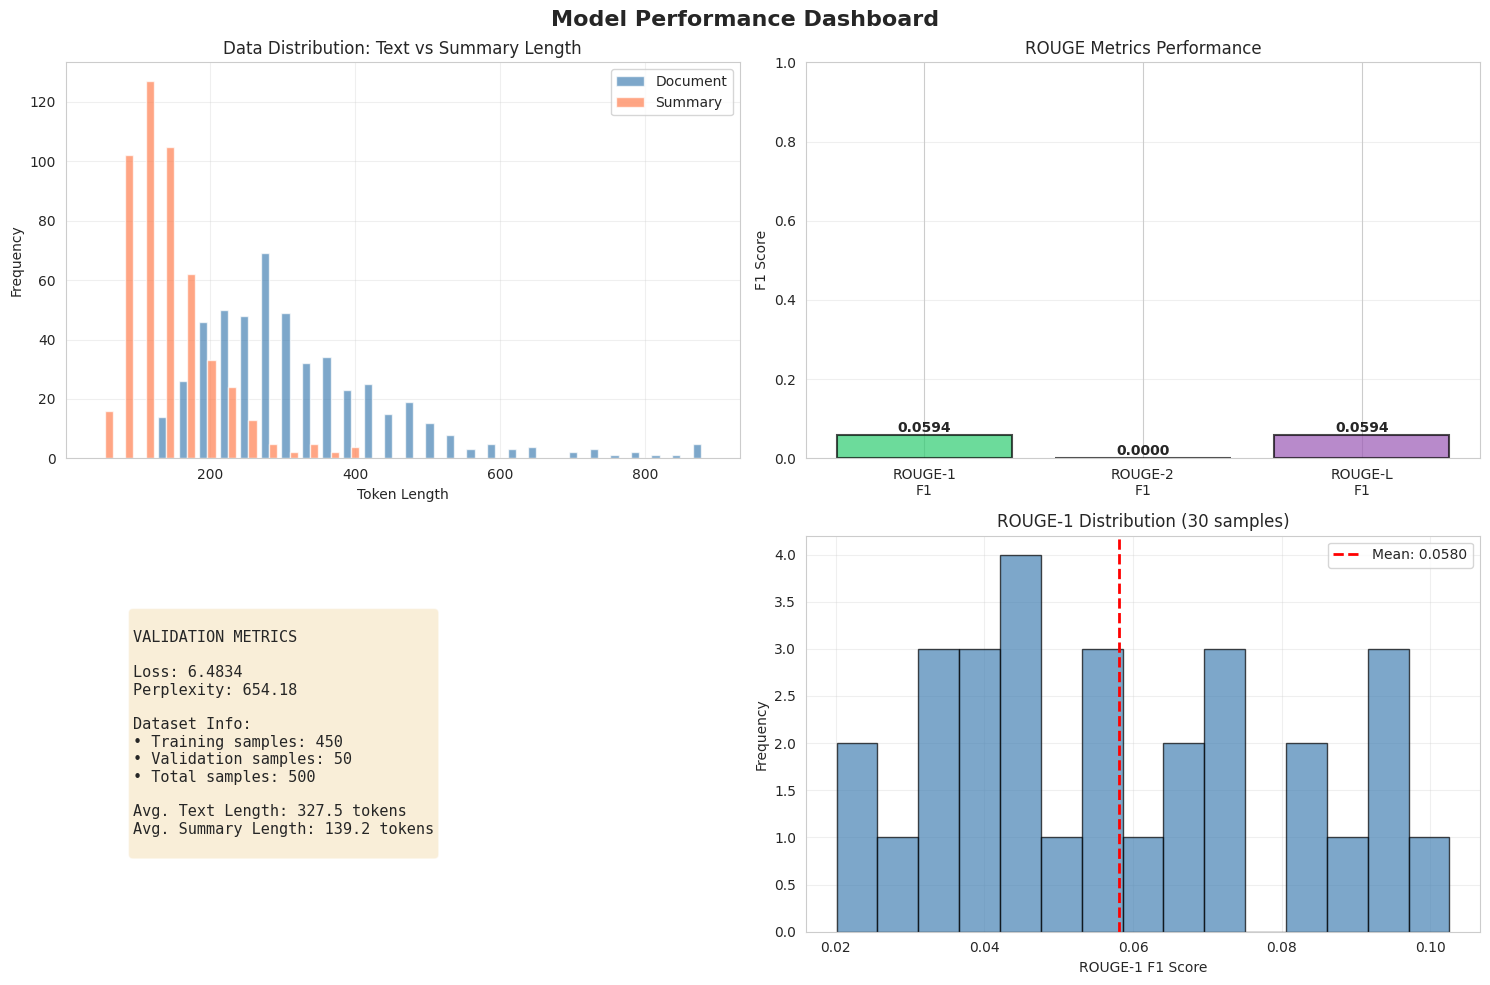


✓ Visualization complete!


In [13]:

# Generate comprehensive performance visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Dashboard', fontsize=16, fontweight='bold')

# 1. Data distribution
ax1 = axes[0, 0]
text_lens = [len(tokenizer._basic_tokens(t)) for t, _ in data]
sum_lens = [len(tokenizer._basic_tokens(s)) for _, s in data]
ax1.hist([text_lens, sum_lens], bins=30, label=['Document', 'Summary'], alpha=0.7, color=['steelblue', 'coral'])
ax1.set_xlabel('Token Length')
ax1.set_ylabel('Frequency')
ax1.set_title('Data Distribution: Text vs Summary Length')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Metrics bar chart
ax2 = axes[0, 1]
metrics_names = ['ROUGE-1\nF1', 'ROUGE-2\nF1', 'ROUGE-L\nF1']
metrics_values = [metrics['rouge1_f1'], metrics['rouge2_f1'], metrics['rougel_f1']]
colors = ['#2ecc71', '#3498db', '#9b59b6']
bars = ax2.bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('F1 Score')
ax2.set_title('ROUGE Metrics Performance')
ax2.set_ylim([0, 1.0])
ax2.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar, val in zip(bars, metrics_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

# 3. Validation loss indicator
ax3 = axes[1, 0]
ax3.axis('off')
loss_text = f"""
VALIDATION METRICS

Loss: {metrics['val_loss']:.4f}
Perplexity: {math.exp(metrics['val_loss']):.2f}

Dataset Info:
• Training samples: {len(train_data)}
• Validation samples: {len(val_data)}
• Total samples: {len(data)}

Avg. Text Length: {np.mean(text_lens):.1f} tokens
Avg. Summary Length: {np.mean(sum_lens):.1f} tokens
"""
ax3.text(0.1, 0.5, loss_text, fontsize=11, verticalalignment='center',
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Sample quality distribution (from multiple samples)
ax4 = axes[1, 1]
sample_rouge_scores = []
sample_sizes = min(30, len(val_data))
sample_indices = random.sample(range(len(val_data)), k=sample_sizes)
for idx in sample_indices:
    text, ref = val_data[idx]
    pred = greedy_decode(model, text, MAX_SUMMARY_LEN)
    r1, r2, rl = rouge_all(ref, pred)
    sample_rouge_scores.append(r1['f1'])

ax4.hist(sample_rouge_scores, bins=15, color='steelblue', alpha=0.7, edgecolor='black')
ax4.axvline(np.mean(sample_rouge_scores), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sample_rouge_scores):.4f}')
ax4.set_xlabel('ROUGE-1 F1 Score')
ax4.set_ylabel('Frequency')
ax4.set_title(f'ROUGE-1 Distribution ({sample_sizes} samples)')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Visualization complete!")


In [14]:

# Detailed sample analysis with quality ranking
@torch.no_grad()
def analyze_model_samples(model, data, num_samples=5):
    """Generate predictions with detailed metrics for samples"""
    model.eval()
    results = []
    
    sample_indices = random.sample(range(len(data)), k=min(num_samples, len(data)))
    
    for idx in tqdm(sample_indices, desc="Analyzing samples"):
        text, ref = data[idx]
        pred = greedy_decode(model, text, MAX_SUMMARY_LEN)
        r1, r2, rl = rouge_all(ref, pred)
        
        results.append({
            'text': text,
            'reference': ref,
            'prediction': pred,
            'rouge1_f1': r1['f1'],
            'rouge2_f1': r2['f1'],
            'rougel_f1': rl['f1'],
            'avg_f1': (r1['f1'] + r2['f1'] + rl['f1']) / 3
        })
    
    return sorted(results, key=lambda x: x['avg_f1'], reverse=True)

print("\n=== DETAILED SAMPLE ANALYSIS ===\n")
analyzed_samples = analyze_model_samples(model, val_data, num_samples=5)

for i, sample in enumerate(analyzed_samples, 1):
    print(f"\n{'='*100}")
    print(f"SAMPLE {i} | Avg ROUGE F1: {sample['avg_f1']:.4f}")
    print(f"{'='*100}")
    print(f"\nDOCUMENT:\n{sample['text'][:300]}{'...' if len(sample['text']) > 300 else ''}")
    print(f"\nREFERENCE SUMMARY:\n{sample['reference']}")
    print(f"\nPREDICTED SUMMARY:\n{sample['prediction']}")
    print(f"\nMETRICS:")
    print(f"  ROUGE-1 F1: {sample['rouge1_f1']:.4f}")
    print(f"  ROUGE-2 F1: {sample['rouge2_f1']:.4f}")
    print(f"  ROUGE-L F1: {sample['rougel_f1']:.4f}")



=== DETAILED SAMPLE ANALYSIS ===



Analyzing samples: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


SAMPLE 1 | Avg ROUGE F1: 0.0553

DOCUMENT:
Gazprom 'in $36m back-tax claim'

The nuclear unit of Russian energy giant Gazprom is reportedly facing a 1bn rouble ($35.7m; Â£19.1m) back-tax claim for the 2001-2003 period.

Vedomosti newspaper reported that Russian authorities made the demand at the end of last year. The paper added that most of...

REFERENCE SUMMARY:
Gazprom is set to merge with state oil firm Rosneft, the company that eventually acquired Yuganskneftegas, the main unit of embattled oil giant Yukos.Gazprom is one of the key players in the complex Russian energy market, where the government of Vladimir Putin has made moves to regain state influence over the sector.The nuclear unit of Russian energy giant Gazprom is reportedly facing a 1bn rouble ($35.7m; Â£19.1m) back-tax claim for the 2001-2003 period.Gazprom, the biggest gas company in the world, took over nuclear fuel giant Atomstroieksport in October 2004.

PREDICTED SUMMARY:
the the the the the the the the the the the